In [29]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('../..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se

import warnings
warnings.filterwarnings('ignore')
import math

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
df = pd.read_csv('../../Datos/df_predecir_0.csv', index_col=0)

In [31]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,cluster
0,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.971,915.49,Medium,0
1,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.540,910.16,Medium,0
2,22732,IN-2013-42360,28-06-2013,01-07-2013,Second Class,JM-15655,Jim Mitchum,Corporate,Sydney,New South Wales,Australia,NaN,APAC,Oceania,TEC-PH-10000030,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.675,5,0.1,763.275,897.35,Critical,0
3,30570,IN-2011-81826,07-11-2011,09-11-2011,First Class,TS-21340,Toby Swindell,Consumer,Porirua,Wellington,New Zealand,NaN,APAC,Oceania,FUR-CH-10004050,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.080,4,0.0,564.840,894.77,Critical,0
4,40155,CA-2014-135909,14-10-2014,21-10-2014,Standard Class,JW-15220,Jane Waco,Corporate,Sacramento,California,United States,95823.0,US,West,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,5083.960,5,0.2,1906.485,867.69,Low,0


In [32]:
df.drop(columns=['State', 'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'City', 'Postal Code','Product ID', 'Product Name', 'Profit', 'cluster', 'Customer Name'], inplace=True)

In [ ]:
df.head()

,Ship Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Shipping Cost,Order Priority
0,First Class,Consumer,Australia,APAC,Oceania,Technology,Phones,5175.171,9,0.1,915.49,Medium
1,First Class,Home Office,Germany,EU,Central,Technology,Phones,2892.510,5,0.1,910.16,Medium
2,Second Class,Corporate,Australia,APAC,Oceania,Technology,Phones,2862.675,5,0.1,897.35,Critical
3,First Class,Consumer,New Zealand,APAC,Oceania,Furniture,Chairs,1822.080,4,0.0,894.77,Critical
4,Standard Class,Corporate,United States,US,West,Office Supplies,Binders,5083.960,5,0.2,867.69,Low


Dejo como nuevas variables, Country y Region. Debido a que en mi modelo anterior estaba cargado por underfitting, ahora meto nuevas variables para intentar mejorar el modelo.

In [34]:
f.exploracion_dataframe(df, 'Sales')

El número de datos es 20567 y el de columnas es 12

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 1

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Ship Mode,object
Segment,object
Country,object
Market,object
Region,object
Category,object
Sub-Category,object
Sales,float64
Quantity,int64
Discount,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Ship Mode tiene los siguientes valores únicos:


,count
Ship Mode,
Standard Class,12359
Second Class,4017
First Class,3094
Same Day,1097


La columna Segment tiene los siguientes valores únicos:


,count
Segment,
Consumer,10892
Corporate,6218
Home Office,3457


La columna Country tiene los siguientes valores únicos:


,count
Country,
United States,3974
France,1185
Australia,1155
Mexico,1014
China,829
...,...
Slovenia,1
Burundi,1
Central African Republic,1


La columna Market tiene los siguientes valores únicos:


,count
Market,
APAC,4621
EU,4114
LATAM,4053
US,3974
Africa,1859
EMEA,1802
Canada,144


La columna Region tiene los siguientes valores únicos:


,count
Region,
Central,4498
South,2707
North,1865
Africa,1859
EMEA,1802
Oceania,1427
Southeast Asia,1287
West,1260
East,1196


La columna Category tiene los siguientes valores únicos:


,count
Category,
Office Supplies,12293
Technology,4201
Furniture,4073


La columna Sub-Category tiene los siguientes valores únicos:


,count
Sub-Category,
Binders,2377
Storage,2062
Art,1859
Chairs,1437
Phones,1395
Paper,1368
Furnishings,1248
Accessories,1225
Bookcases,1007


La columna Order Priority tiene los siguientes valores únicos:


,count
Order Priority,
Medium,11734
High,6144
Critical,1624
Low,1065


In [35]:
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

df['Discount_Category'] = pd.cut(
    df['Discount'],
    bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
    labels=['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']  # Nombres de las categorías
)

df['Quantity_Group'] = pd.cut(
    df['Quantity'],
    bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
    labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
)

df.drop(columns=['Quantity', 'Discount'], inplace=True)

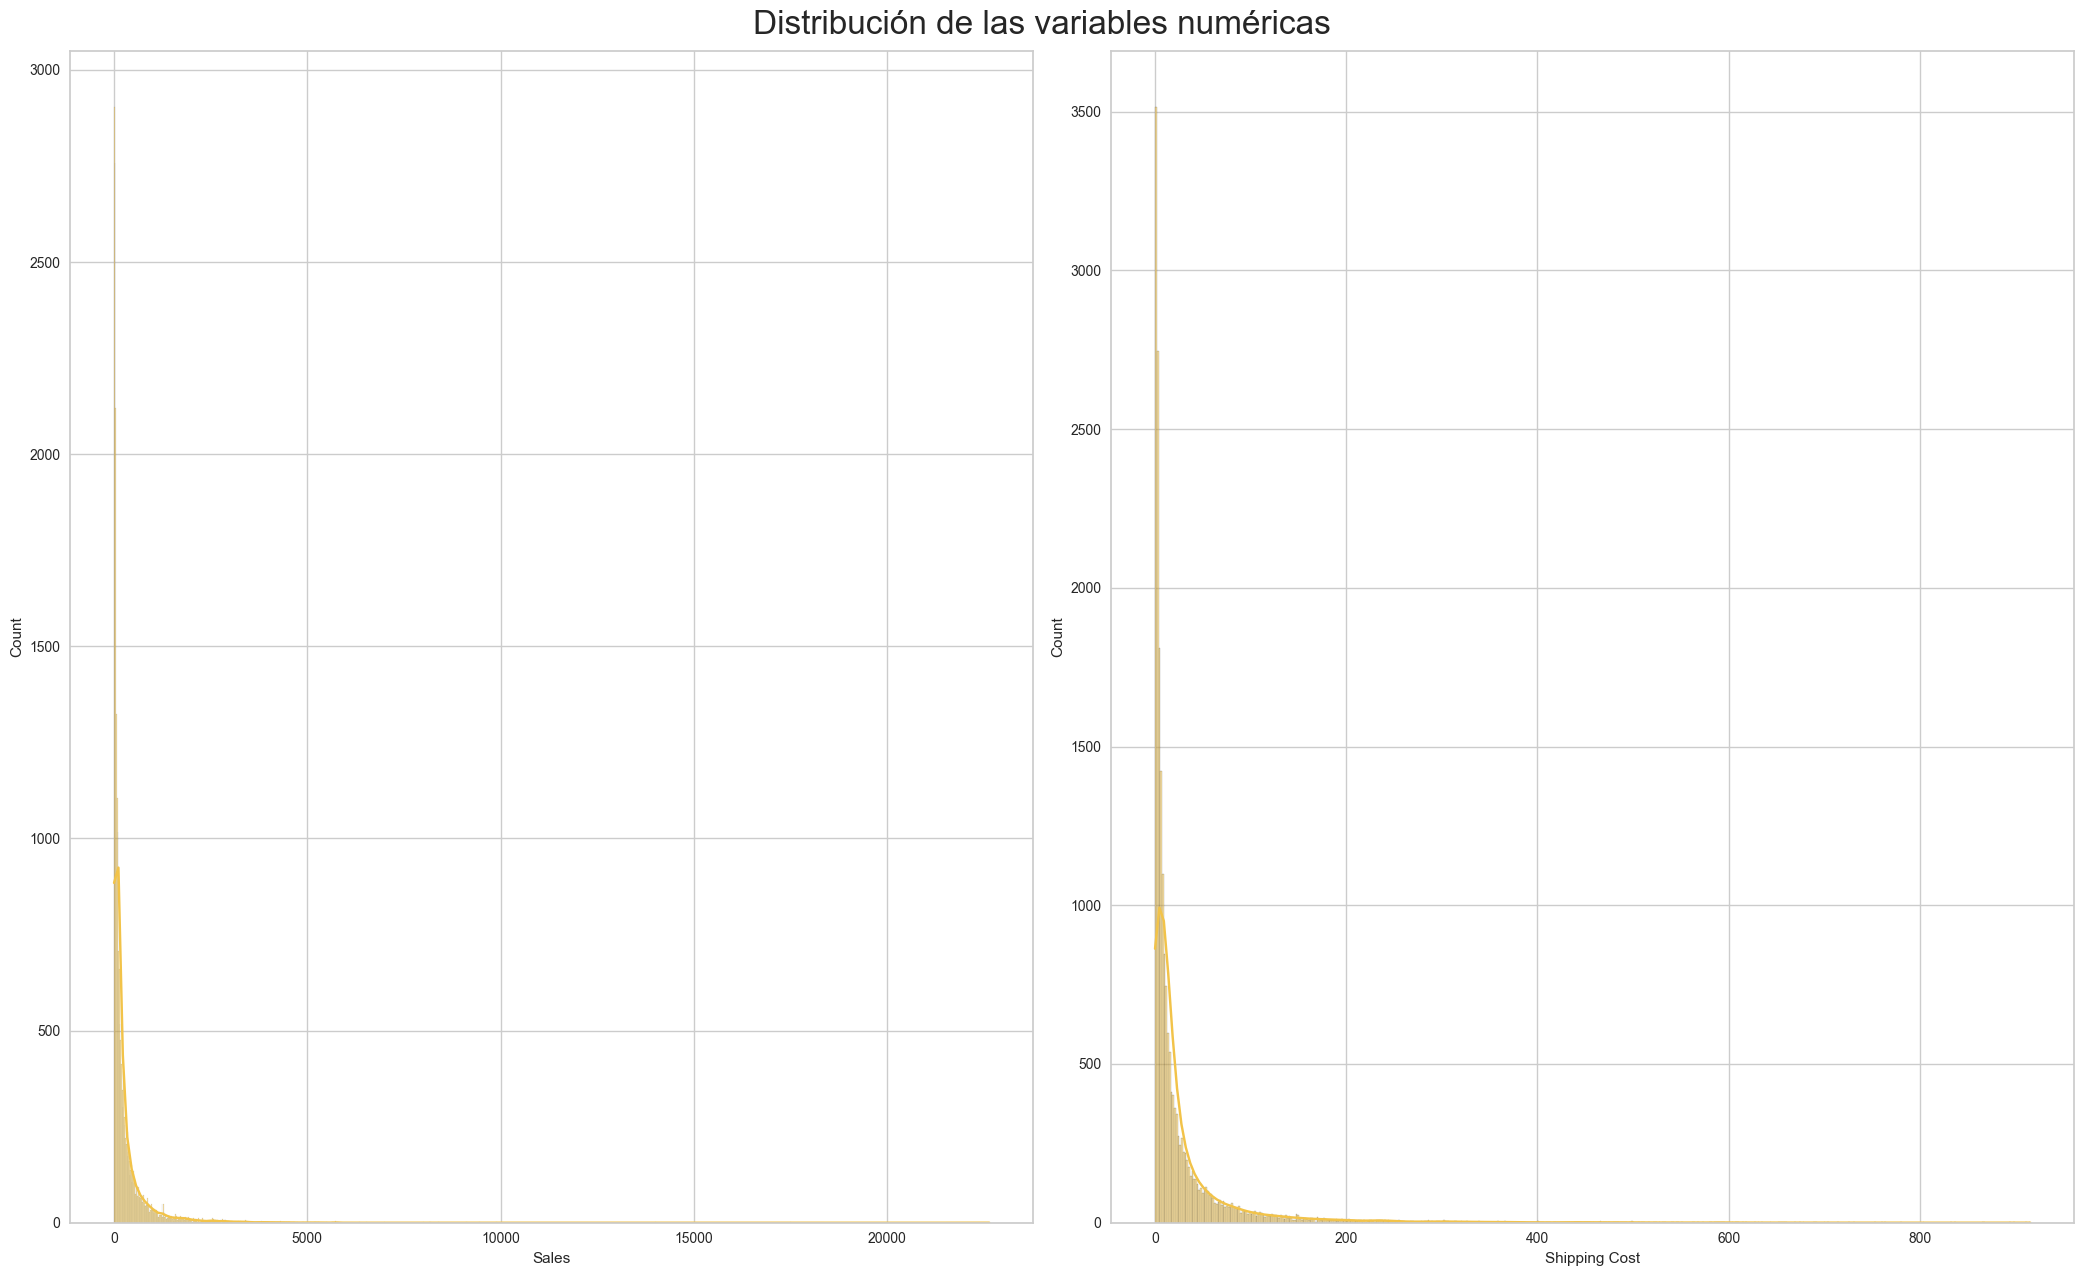

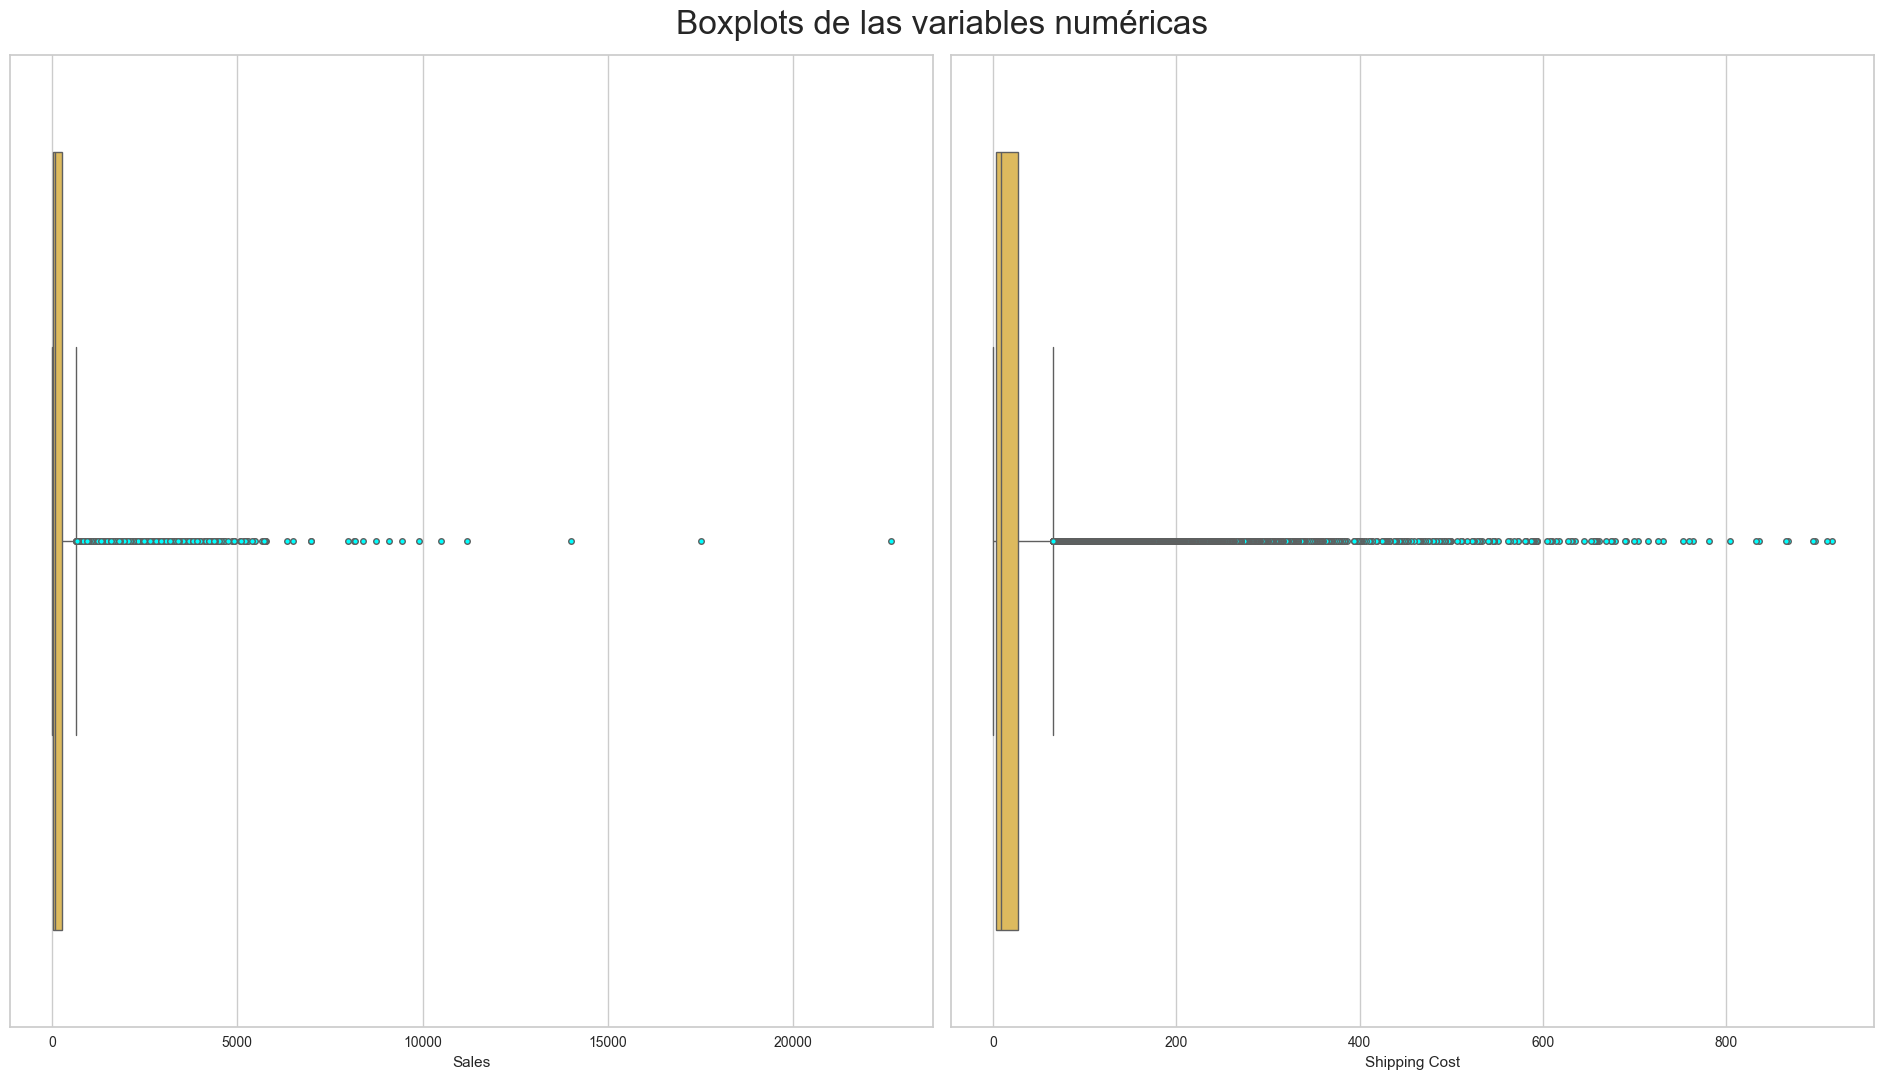

In [36]:
preprocesar_cluster = sc.Exploracion(df)
preprocesar_cluster.visualizar_numericas()

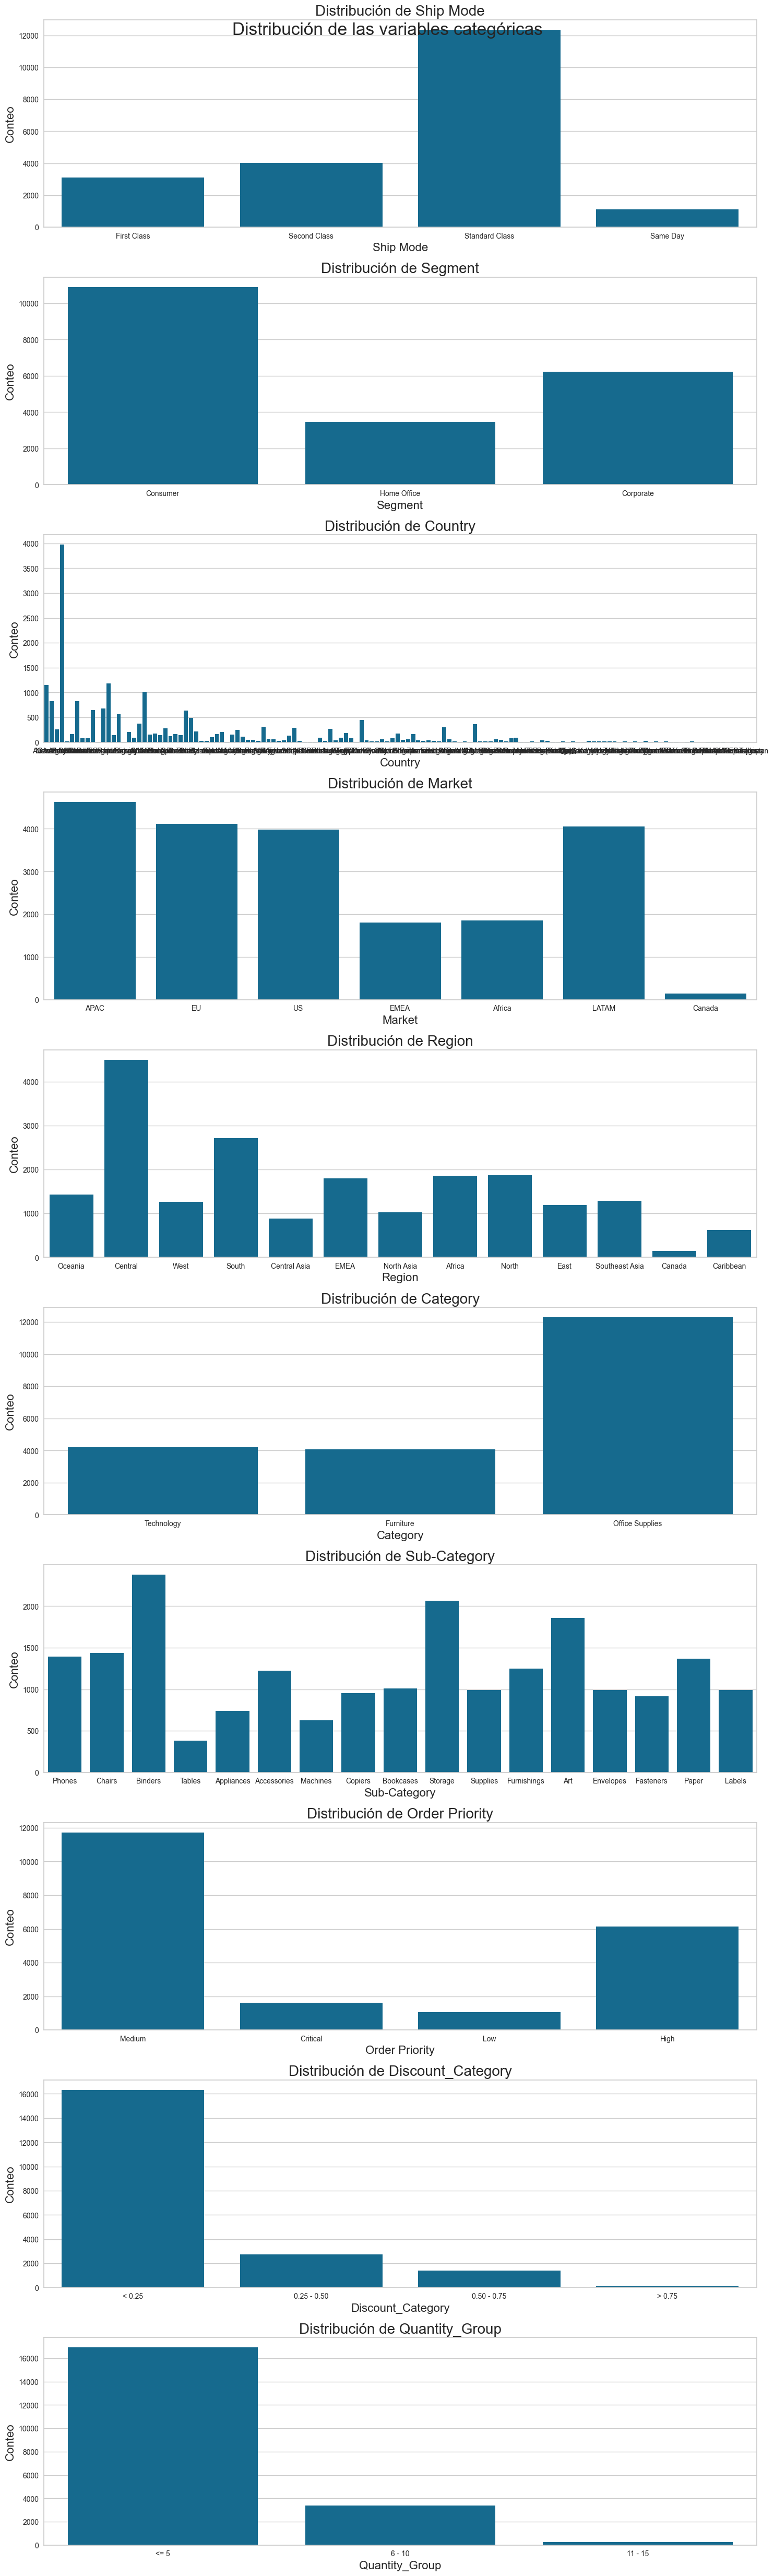

In [37]:
preprocesar_cluster.visualizar_categoricas()

## Estandarizar 

In [38]:
lista_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist() # saco mis columnas numéricas

if 'Sales' in lista_num:
    lista_num.remove('Sales')

In [39]:
f.escalar_columnas_metodo(df, lista_num, 'robust')

,Ship Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
0,First Class,Consumer,Australia,APAC,Oceania,Technology,Phones,5175.171,36.402569,Medium,< 0.25,6 - 10
1,First Class,Home Office,Germany,EU,Central,Technology,Phones,2892.510,36.188641,Medium,< 0.25,<= 5
2,Second Class,Corporate,Australia,APAC,Oceania,Technology,Phones,2862.675,35.674493,Critical,< 0.25,<= 5
3,First Class,Consumer,New Zealand,APAC,Oceania,Furniture,Chairs,1822.080,35.570941,Critical,< 0.25,<= 5
4,Standard Class,Corporate,United States,US,West,Office Supplies,Binders,5083.960,34.484046,Low,< 0.25,<= 5
...,...,...,...,...,...,...,...,...,...,...,...,...
20562,First Class,Home Office,Nicaragua,LATAM,Central,Office Supplies,Paper,18.640,-0.341561,Medium,< 0.25,<= 5
20563,Same Day,Corporate,India,APAC,Central Asia,Office Supplies,Paper,26.940,-0.341561,High,< 0.25,<= 5
20564,Standard Class,Consumer,United States,US,Central,Office Supplies,Appliances,0.444,-0.341561,Medium,> 0.75,<= 5
20565,Same Day,Home Office,United States,US,West,Office Supplies,Envelopes,22.920,-0.341561,High,< 0.25,<= 5


In [40]:
lista_col_cat = df.select_dtypes(include=['object', 'category'])

In [41]:
asunciones = se.Asunciones(dataframe=df, columna_numerica='Sales')

for categoria in lista_col_cat:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df, "Sales", categoria)
    test.run_all_tests()
    print("\n###########################\n")

Estamos analizando la variable SHIP MODE
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['First Class', 'Second Class', 'Standard Class', 'Same Day']

Realizando test de Kruskal...
Estadístico de prueba: 3.3511073437616696
Valor p: 0.3405925623314053
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-18.1497,0.8329,-73.3387,37.0393,First Class-Same Day
1,1.6124,0.9995,-35.9550,39.1798,First Class-Second Class
2,-2.3647,0.9975,-33.9374,29.2079,First Class-Standard Class
3,19.7621,0.7783,-33.7415,73.2657,Same Day-Second Class
4,15.7849,0.8452,-33.6939,65.2638,Same Day-Standard Class
5,-3.9771,0.9843,-32.5016,24.5474,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Home Office', 'Corporate']

Realizando test de Kruskal...
Estadístico de prueba: 1.840423575997225
Valor p: 0.39843464847138066
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,9.7151,0.5769,-13.0579,32.4881,Consumer-Corporate
1,2.4589,0.9769,-25.5104,30.4282,Consumer-Home Office
2,-7.2562,0.8416,-37.6528,23.1404,Corporate-Home Office



###########################

Estamos analizando la variable COUNTRY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Country las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Australia', 'Germany', 'New Zealand', 'United States', 'Afghanistan', 'Saudi Arabia', 'China', 'Tanzania', 'Poland', 'United Kingdom', 'Taiwan', 'India', 'France', 'Democratic Republic of the Congo', 'Indonesia', 'Uruguay', 'Iran', 'Bangladesh', 'Spain', 'Mexico', 'Ukraine', 'Morocco', 'Canada', 'Philippines', 'Austria', 'Colombia', 'Thailand', 'Brazil', 'Italy', 'Guatemala', 'Belarus', 'Cambodia', 'Japan', 'Russia', 'South Africa', 'Azerbaijan', 'Argentina', 'Nicaragua', 'Vietnam', 'Senegal', 'Cameroon', 'Hungary', 'El Salvador', 'Malaysia', 'Belgium', 'Finland', 'Mozambique', 'Iraq', 'Cuba', 'Switzerland', 'Albania', 'Chad', 'Namibia', 'Pakistan', 'Portugal', 'Dominican Republic', 'Norway', 'Algeria', 'Egyp

,meandiff,p-adj,lower,upper,group_diff
0,179.9540,1.0000,-1521.9005,1881.8085,Afghanistan-Albania
1,-327.2001,1.0000,-1074.8209,420.4207,Afghanistan-Algeria
2,-413.7639,1.0000,-1194.6283,367.1005,Afghanistan-Angola
3,-425.7772,0.9997,-1154.0318,302.4775,Afghanistan-Argentina
4,-511.5260,1.0000,-2213.3805,1190.3285,Afghanistan-Armenia
...,...,...,...,...,...
9448,-1.4487,1.0000,-515.3512,512.4538,Vietnam-Zambia
9449,-273.9078,1.0000,-833.0545,285.2389,Vietnam-Zimbabwe
9450,218.7847,1.0000,-628.7592,1066.3285,Yemen-Zambia
9451,-53.6744,1.0000,-929.3912,822.0423,Yemen-Zimbabwe



###########################

Estamos analizando la variable MARKET
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Market las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['APAC', 'EU', 'US', 'EMEA', 'Africa', 'LATAM', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1044.421547033699
Valor p: 2.203269477409355e-222
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-200.1614,0.0000,-249.3294,-150.9933,APAC-Africa
1,-176.2327,0.0108,-327.7232,-24.7422,APAC-Canada
2,-193.5427,0.0000,-243.2622,-143.8232,APAC-EMEA
3,-60.8024,0.0001,-99.1762,-22.4287,APAC-EU
4,-166.2289,0.0000,-204.7551,-127.7027,APAC-LATAM
5,-93.4375,0.0000,-132.1672,-54.7078,APAC-US
6,23.9287,0.9993,-130.9254,178.7828,Africa-Canada
7,6.6187,0.9999,-52.5628,65.8002,Africa-EMEA
8,139.3589,0.0000,89.3293,189.3886,Africa-EU
9,33.9324,0.4176,-16.2143,84.0791,Africa-LATAM



###########################

Estamos analizando la variable REGION
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Region las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Oceania', 'Central', 'West', 'South', 'Central Asia', 'EMEA', 'North Asia', 'Africa', 'North', 'East', 'Southeast Asia', 'Canada', 'Caribbean']

Realizando test de Kruskal...
Estadístico de prueba: 783.5231810589512
Valor p: 5.644105358448363e-160
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,23.9287,1.0000,-150.1977,198.0550,Africa-Canada
1,6.5148,1.0000,-87.1266,100.1561,Africa-Caribbean
2,100.8570,0.0000,45.3533,156.3606,Africa-Central
3,262.1766,0.0000,179.7446,344.6085,Africa-Central Asia
4,6.6187,1.0000,-59.9282,73.1656,Africa-EMEA
...,...,...,...,...,...
73,-49.8101,0.6407,-127.1936,27.5735,Oceania-Southeast Asia
74,-117.7471,0.0000,-195.5654,-39.9289,Oceania-West
75,50.9644,0.3896,-17.1934,119.1222,South-Southeast Asia
76,-16.9726,0.9998,-85.6236,51.6784,South-West



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Furniture', 'Office Supplies']

Realizando test de Kruskal...
Estadístico de prueba: 6027.55775508947
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-338.6123,0.0,-363.2787,-313.9459,Furniture-Office Supplies
1,76.5646,0.0,46.5630,106.5663,Furniture-Technology
2,415.1769,0.0,390.7944,439.5594,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Phones', 'Chairs', 'Binders', 'Tables', 'Appliances', 'Accessories', 'Machines', 'Copiers', 'Bookcases', 'Storage', 'Supplies', 'Furnishings', 'Art', 'Envelopes', 'Fasteners', 'Paper', 'Labels']

Realizando test de Kruskal...
Estadístico de prueba: 10252.501616569542
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,427.1203,0.0,338.4987,515.7418,Accessories-Appliances
1,-199.5179,0.0,-269.4765,-129.5593,Accessories-Art
2,-182.9019,0.0,-249.7641,-116.0397,Accessories-Binders
3,386.3314,0.0,305.4673,467.1956,Accessories-Bookcases
4,228.5462,0.0,154.6198,302.4725,Accessories-Chairs
...,...,...,...,...,...
131,-494.2396,0.0,-573.1705,-415.3087,Phones-Supplies
132,434.7136,0.0,324.8223,544.6050,Phones-Tables
133,-126.2007,0.0,-199.6315,-52.7699,Storage-Supplies
134,802.7525,0.0,696.7426,908.7625,Storage-Tables



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Medium', 'Critical', 'Low', 'High']

Realizando test de Kruskal...
Estadístico de prueba: 1.3433820117528967
Valor p: 0.7188582633955443
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,4.6798,0.9928,-39.1394,48.4991,Critical-High
1,-24.7950,0.7326,-86.7186,37.1286,Critical-Low
2,10.8498,0.9083,-30.7301,52.4297,Critical-Medium
3,-29.4749,0.4664,-81.6022,22.6525,High-Low
4,6.1699,0.9187,-18.5609,30.9008,High-Medium
5,35.6448,0.2628,-14.6148,85.9044,Low-Medium



###########################

Estamos analizando la variable DISCOUNT_CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Discount_Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']

Realizando test de Kruskal...
Estadístico de prueba: 983.8231515462476
Valor p: 5.812412157036999e-213
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-149.8914,0.0000,-201.4559,-98.3270,0.25 - 0.50-0.50 - 0.75
1,67.3691,0.0000,35.0932,99.6450,0.25 - 0.50-< 0.25
2,-194.0130,0.0045,-342.8070,-45.2189,0.25 - 0.50-> 0.75
3,217.2605,0.0000,173.4836,261.0375,0.50 - 0.75-< 0.25
4,-44.1215,0.8779,-195.8264,107.5834,0.50 - 0.75-> 0.75
5,-261.3820,0.0000,-407.6599,-115.1042,< 0.25-> 0.75



###########################

Estamos analizando la variable QUANTITY_GROUP
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Quantity_Group las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['6 - 10', '<= 5', '11 - 15']

Realizando test de Kruskal...
Estadístico de prueba: 1689.5031386565245
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-373.8331,0.0,-463.6834,-283.9829,11 - 15-6 - 10
1,-761.4940,0.0,-848.7948,-674.1932,11 - 15-<= 5
2,-387.6609,0.0,-413.6783,-361.6435,6 - 10-<= 5



###########################



- Resultados:
    - Ship Mode: no tiene orden
    - Segment: no tiene orden.
    - Country: tiene orden.
    - Market : tiene orden
    - Region: tiene orden
    - Category: tiene orden.
    - Sub-Category: tiene orden
    - Order Priotity: no tiene orden.
    - Discount Category: tiene orden.
    - Quantity Group: tiene orden.

In [42]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment', 'Order Priority'], # no metemos ninguna columna porque todas nuestras columnas tienen orden
                        "dummies": [], # no metemos ninguna columna porque todas tienen orden
                        'ordinal' : {},
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["Country", "Region", "Market", "Category", "Sub-Category", "Discount_Category", "Quantity_Group"]
                        }

In [43]:
encoding = se.Encoding(df, diccionario_encoding, "Sales")
df_encode = encoding.one_hot_encoding()
df_encode = encoding.target_encoding()
df_encode.head()

,Ship Mode,Segment,Sales,Shipping Cost,Order Priority,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Country,Region,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,First Class,Consumer,5175.171,36.402569,Medium,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,389.355572,376.016944,387.974849,557.550307,590.015969,315.266849,601.339346
1,First Class,Home Office,2892.510,36.188641,Medium,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,328.616717,294.551347,331.837571,560.247600,617.748325,317.957078,217.412934
2,Second Class,Corporate,2862.675,35.674493,Critical,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,398.159796,383.684761,384.386158,550.723353,604.896927,316.184040,217.338230
3,First Class,Consumer,1822.080,35.570941,Critical,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,306.486498,385.295329,394.028902,472.155097,495.166822,312.282376,214.655783
4,Standard Class,Corporate,5083.960,34.484046,Low,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,296.790800,255.967758,296.790800,138.996303,92.956661,317.957078,217.412934


In [44]:
df_encode.drop(columns=['Ship Mode', 'Segment', 'Order Priority'], inplace=True)

In [45]:
df_encode.shape

(20567, 20)

In [46]:
df_encode.to_csv('../../Datos/Datos_Modelo_2/Modelo_2_CL_0.csv')